In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline

Using TensorFlow backend.


In [2]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
maxlen = 100
training_samples = 8000
validation_samples = 10000
max_words = 10000

In [4]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [5]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [7]:
glove_dir = 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0122 21:59:57.680747 12256 deprecation_wrapper.py:119] From D:\Applications\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0122 21:59:57.698737 12256 deprecation_wrapper.py:119] From D:\Applications\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0122 21:59:57.700693 12256 deprecation_wrapper.py:119] From D:\Applications\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 80008     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,080,729
Trainable params: 1,080,729
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0122 21:59:57.795438 12256 deprecation_wrapper.py:119] From D:\Applications\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0122 21:59:57.797432 12256 deprecation_wrapper.py:119] From D:\Applications\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [11]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

W0122 21:59:59.695968 12256 deprecation_wrapper.py:119] From D:\Applications\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0122 21:59:59.724890 12256 deprecation.py:323] From D:\Applications\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/40
8000/8000 [==============================] - 2s 245us/step - loss: 0.6948 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.5001
Epoch 2/40
8000/8000 [==============================] - 1s 166us/step - loss: 0.6955 - acc: 0.4988 - val_loss: 0.6929 - val_acc: 0.5034
Epoch 3/40
8000/8000 [==============================] - 1s 174us/step - loss: 0.6867 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5309
Epoch 4/40
8000/8000 [==============================] - 1s 170us/step - loss: 0.6179 - acc: 0.6770 - val_loss: 0.6860 - val_acc: 0.6140
Epoch 5/40
8000/8000 [==============================] - 1s 183us/step - loss: 0.5337 - acc: 0.7406 - val_loss: 0.6451 - val_acc: 0.6477
Epoch 6/40
8000/8000 [==============================] - 2s 191us/step - loss: 0.4675 - acc: 0.7864 - val_loss: 0.6184 - val_acc: 0.6864
Epoch 7/40
8000/8000 [==============================] - 1s 164us/step - loss: 0.4048 - acc: 0.8260 - val_loss: 0.7353 - val_acc: 0.6692

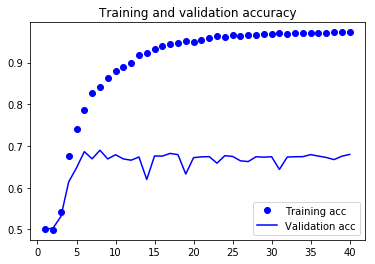

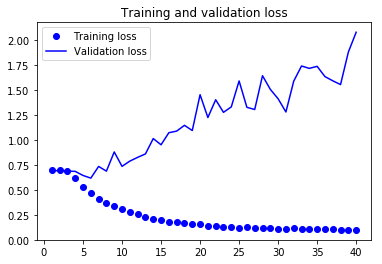

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [13]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [14]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 57us/step


[2.0822104966545103, 0.67744]